In [16]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
import os
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d
import scipy as sp

In [2]:
def resample(s: pd.Series) -> pd.Series:
    """
    Resample a pandas Series with unevenly spaced time indices to be even.

    Parameters
    ----------
    s : pd.Series
        The input signal as a pandas Series. The Series index should be time.

    Returns
    -------
    tuple
        The resampled signal as a pandas Series, resampling period as a float,
        and new timebase as a numpy array.
    """
    assert isinstance(s, pd.Series)
    
    # Resampling parameters - change these to suit your data
    resampling_period = s.index.to_series().diff().mean()
    
    # Interpolate to a new time base (resample)
    f_interp = interp1d(s.index, s.values, kind='linear',
                        fill_value='extrapolate')
    new_timebase = np.arange(s.index.min(), s.index.max(), resampling_period)
    if new_timebase[-1] < s.index.max():
        new_timebase = np.append(new_timebase, s.index.max())
    s_interpolated = pd.Series(f_interp(new_timebase), index=new_timebase)
    
    return s_interpolated, resampling_period, new_timebase


def lowpass_filter_series(s: pd.Series, cutoff_freq: float, 
                          butterworth_order: int) -> pd.Series:
    """
    Apply a lowpass Butterworth filter to a pandas Series with uneven time
    indices.

    Parameters
    ----------
    s : pd.Series
        The input signal as a pandas Series. The Series index should be time.
    cutoff_freq : float
        The cutoff frequency for the lowpass filter.
    butterworth_order : int
        The order of the Butterworth filter.

    Returns
    -------
    pd.Series
        The filtered signal as a pandas Series.
    """
    s_interpolated, resampling_period, new_timebase = resample(s)

    # Create the low-pass filter
    nyquist_rate = 0.5 / resampling_period
    normalized_cutoff_freq = cutoff_freq / nyquist_rate
    b, a = signal.butter(butterworth_order, normalized_cutoff_freq, 
                         btype='low')
    
    # Apply the low-pass filter
    filtered_signal = signal.filtfilt(b, a, s_interpolated)
    s_filtered_interpolated = pd.Series(filtered_signal, 
                                        index=new_timebase)

    # Interpolate back to the original timebase
    f_interp_back = interp1d(s_filtered_interpolated.index, 
                             s_filtered_interpolated.values, kind='linear')
    s_filtered = pd.Series(f_interp_back(s.index), index=s.index)

    return s_filtered


def z_transform_series(s: pd.Series, a: list, b: list) -> pd.Series:
    """
    Apply a Z-transform to a pandas Series with unevenly spaced time indices.

    Parameters
    ----------
    s : pd.Series
        The input signal as a pandas Series. The Series index should be time.
    a : list
        The denominator coefficient vector in a 1-D sequence (filter's recursive part).
    b : list
        The numerator coefficient vector in a 1-D sequence (filter's non-recursive part).

    Returns
    -------
    pd.Series
        The transformed signal as a pandas Series.
    """
    s_interpolated, _, new_timebase = resample(s)

    # Apply the Z-transform
    transformed_signal = signal.lfilter(b, a, s_interpolated)
    s_transformed_interpolated = pd.Series(transformed_signal, 
                                           index=new_timebase)

    # Interpolate back to the original timebase
    f_interp_back = interp1d(s_transformed_interpolated.index, 
                             s_transformed_interpolated.values, kind='linear')
    s_transformed = pd.Series(f_interp_back(s.index), index=s.index)

    return s_transformed

In [3]:
dfs = {
    'temperature': pd.DataFrame(index=np.arange(4600), dtype=float),
    'seconds': pd.DataFrame(index=np.arange(4600), dtype=float),
    'heat': pd.DataFrame(index=np.arange(4600), dtype=float)
}

for filename in os.listdir('../logs/'):
    df_read = pd.read_csv(f'../logs/{filename}', header=None)[0].values
    if len(df_read) > 4600:
        continue
    df_read = np.pad(
        df_read, ((0, 4600-len(df_read)),), 'constant', constant_values=np.nan
    )

    keys = filename.split('.')[0].split('_')
    datatype = keys[1]
    timestamp = keys[-1]

    if datatype not in dfs.keys():
        continue
    dfs[datatype][timestamp] = df_read

dfs = {
    key: df.set_index([pd.MultiIndex.from_product([[key], df.index])]) 
    for key, df in dfs.items()
}

combined = pd.concat(dfs.values(), axis=0)
null_heats = [
    colname for colname in combined.columns 
    if np.isnan(combined.loc['heat', colname].iloc[0])
]
combined.drop(columns=null_heats, inplace=True)
null_heats = [
    colname for colname in combined.columns 
    if int(np.round(6*np.max(combined[colname].loc['heat']))) == 6 
    and (combined[colname].loc['seconds'] > 0).sum() < 600
]
combined.drop(columns=null_heats, inplace=True)
combined.rename(
    lambda x: int(np.round(6*np.max(combined[x].loc['heat']))), 
    axis=1,
    inplace=True
)

In [4]:
indices = [2, 4, 5, 6]

turnon = {}
for i in indices:
    turnon[i] = np.argmax(combined.loc['heat'][i])

startidx = {}
for i in indices:
    startidx[i] = np.argmin(combined.loc['temperature'][i].iloc[:turnon[i]+10])

# hit10 = {}
# for i in indices:
#     temp_curve = combined.loc['temperature'][i]
#     wherelarge = temp_curve[temp_curve > 10]
#     if len(wherelarge) > 0:
#         hit10[i] = np.argmax(temp_curve > 10)
#     else:
#         hit10[i] = -1

turnoff = {}
for i in indices:
    turnoff[i] = np.argmin(combined.loc['heat'][i].iloc[turnon[i]:]) + turnon[i]

endidx = {}
for i in indices:
    endidx[i] = np.argmax(np.isnan(combined.loc['heat'][i]))

temps_series = {}
for i in indices:
    secs = combined.loc['seconds'][i].iloc[turnon[i]:endidx[i]].values
    secs -= secs[0]
    temps = combined.loc['temperature'][i].iloc[turnon[i]:endidx[i]].values
    temps_series[i] = pd.Series(temps, index=secs)

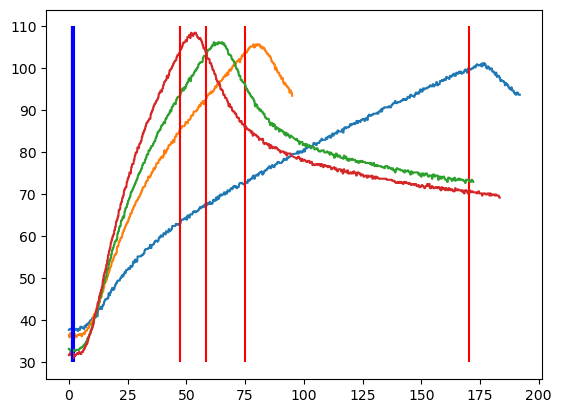

In [5]:
for i in indices:
    # secs = combined.loc['seconds'][i].iloc[turnon[i]:turnoff[i]].values
    secs = combined.loc['seconds'][i].values
    secs -= secs[0]
    plt.plot(
        secs,
        # combined.loc['temperature'][i].iloc[turnon[i]:turnoff[i]].values,
        combined.loc['temperature'][i].values,
        label=str(i)
    )
    start = combined.loc['seconds'][i].iloc[turnon[i]]
    stop = combined.loc['seconds'][i].iloc[turnoff[i]]
    plt.vlines(start, 30, 110, label="start", color="blue")
    plt.vlines(stop, 30, 110, label="end", color="red")

In [6]:
# preprocess data
data = {}
for i in indices:
    # time
    secs = combined.loc['seconds'][i].values
    secs -= secs[0]
    start = combined.loc['seconds'][i].iloc[turnon[i]]
    stop = combined.loc['seconds'][i].iloc[turnoff[i]]

    # control
    heat_level = i / 6.0
    u = np.array([heat_level if s >= start and s <= stop else 0.0 for s in secs])

    # temp
    T = combined.loc['temperature'][i].values

    idx = np.isfinite(secs)
    data[i] = {
        "t": secs[idx],
        "u": u[idx],
        "T": T[idx]
    }

# dynamics fitting - torchdiffeq

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torchdiffeq import odeint
# from torchdiffeq import odeint_adjoint as odeint


class LinearDynamics(nn.Module):
    """ Linear dynamics: x' = Ax + Bu """
    def __init__(self, n, m=1):
        super().__init__()
        self.n = n
        self.m = m

        self.A = nn.Parameter(torch.zeros(n, n))
        self.B = nn.Parameter(torch.randn(n, 1))
        self.c = nn.Parameter(torch.randn(n))

    def forward(self, t, x, u=None):
        return F.linear(x, self.A, bias=self.c) + F.linear(u, self.B)

class LookupLinearInterpolator:
    """
        Interpolator requires init_interpolation to be called
        before querying
    """
    def __init__(self):
        # input sequence to be interpolated
        self.t_seq = None
        self.u_seq = None
        self.length = 0

    def init_interpolation(self, t_seq, u_seq):
        """ t is 1-D, u has shape (batch_size, time, dim) """
        assert t_seq.shape[0] == u_seq.shape[1]
        self.t_seq = t_seq.detach().cpu().numpy()
        self.u_seq = Variable(u_seq).to(u_seq.device)
        self.length = t_seq.shape[0]

    def __call__(self, t):
        """ return interpolation of loaded input sequence """
        idx_right = np.searchsorted(self.t_seq, t.item(), side='left')
        idx_left = idx_right - 1

        # if extend past sequence, just return last element
        if idx_right == self.length:
            return self.u_seq[:, -1]

        # if hit starting time, return first element
        if idx_right == 0:
            return self.u_seq[:, 0]

        # linear interpolation
        t_left = self.t_seq[idx_left]
        u_left = self.u_seq[:,idx_left]

        u_diff = self.u_seq[:,idx_right] - u_left
        t_diff = self.t_seq[idx_right] - t_left
        slope = u_diff / t_diff

        return slope*(t - t_left) + u_left
    

class DynamicsWrapper(nn.Module):
    """ nn.Module wrapper to ensure that odeint_adjoint works correctly """
    def __init__(self, dynamics, input_interpolator):
        super().__init__()
        self.n = dynamics.n
        self.dynamics = dynamics
        self.input_interpolator = input_interpolator

    def forward(self, t, x):        
        return self.dynamics(t, x, self.input_interpolator(t))
    

class DynamicalSystem(nn.Module):
    def __init__(self, dynamics, interpolator):
        super().__init__()
        self.n = dynamics.n
        self.dynamics = dynamics
        self.interpolator = interpolator
        # self.x0 = nn.Parameter(30.0 * torch.ones(dynamics.n), requires_grad=True)

    def forward(self, t, u, x0):
        self.dynamics.input_interpolator.init_interpolation(t[0,:], u)
        return odeint(self.dynamics, x0, t[0, :], method="rk4", options=dict(step_size=1.0)).permute(1,0,2)
        # return odeint(self.dynamics, x0, t[0, :], method="dopri5").permute(1,0,2)

/opt/homebrew/Caskroom/miniforge/base/envs/veclib/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
n = 5

dynamics = LinearDynamics(n)
interp = LookupLinearInterpolator()
wrapped_dynamics = DynamicsWrapper(dynamics, interp)
model = DynamicalSystem(wrapped_dynamics, interp)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [9]:
# discretization interval
tau = 0.2

# data scaling factor
scale = 100.0

# downsample and scale data
data_interp = {}
for i in indices:
    t, u, T = data[i]["t"], data[i]["u"], data[i]["T"]

    t_interp = np.arange(t[0], t[-1], tau)
    T_interp = np.interp(t_interp, t, T)
    u_interp = np.interp(t_interp, t, u)

    data_interp[i] = {
        "t": t_interp,
        "u": u_interp,
        "T": T_interp / scale,
    }

    print(i, T_interp.shape)

# convert data to torch tensor, and scale data
def convert(d):
    data_torch = {}
    for i in d.keys():
        data_torch[i] = {
            "t": torch.tensor(d[i]["t"]).reshape(1, -1).float(),
            "u": torch.tensor(d[i]["u"]).reshape(1, -1, 1).float(),
            "T": torch.tensor(d[i]["T"]).reshape(1, -1, 1).float(),
        }
        data_torch[i]["x0"] = data_torch[i]["T"][0,0,0].repeat(data_torch[i]["u"].shape[0], n)
    return data_torch

data_torch = convert(data_interp)

2 (960,)
4 (476,)
5 (861,)
6 (917,)


===== Horizon 10 =====
10 0.030362512916326523
===== Horizon 20 =====
10 0.035356637090444565
20 0.01421373151242733
===== Horizon 30 =====
10 0.003058657981455326
20 0.002042005304247141
30 0.0019995439797639847
===== Horizon 40 =====
10 0.001827677944675088
20 0.0009320642566308379
30 0.0006523913471028209
40 0.0005487962043844163
===== Horizon 50 =====
10 0.0007225916488096118
20 0.0005495527293533087
30 0.0005332215805537999
40 0.0005183242610655725
50 0.0005082247662357986
===== Horizon 60 =====
10 0.0009116526925936341
20 0.0008551978971809149
30 0.0007732699741609395
40 0.000747692072764039
50 0.0007317776326090097
60 0.0007162364781834185
===== Horizon 70 =====
10 0.001440622378140688
20 0.00123703689314425
30 0.0011045942083001137
40 0.0010389937087893486
50 0.0009789859177544713
60 0.0009243922540917993
70 0.0008752162102609873
===== Horizon 80 =====
10 0.0014344771625474095
20 0.0012083237525075674
30 0.001062715076841414
40 0.0009482763125561178
50 0.00086846889462322
60 0.

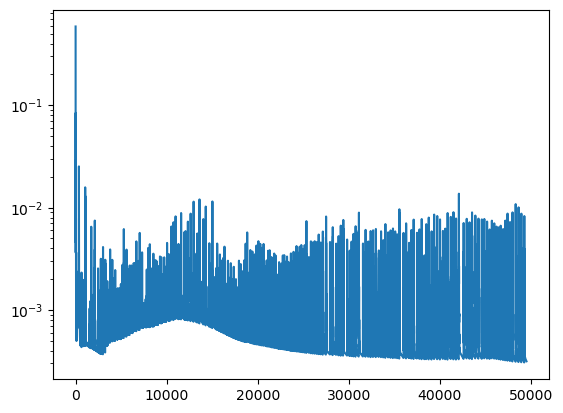

In [10]:
losses = []
# gradually increase fitting horizon
for H in np.arange(10, 1000, 10):
    print("===== Horizon %d =====" % H)
    for g in optimizer.param_groups:
        g['lr'] = 1 / H

    # inner loop
    for itr in range(1, H + 1):
        optimizer.zero_grad()

        # fitting loss
        loss = 0.0
        for i in data_torch.keys():
            T_pred = model(data_torch[i]["t"][:,:H], data_torch[i]["u"][:,:H], data_torch[i]["x0"])
            loss += (T_pred[0,:,0] - data_torch[i]["T"][0,:H,0]).pow(2).mean()

        # regularization
        loss += 1e-5 * model.dynamics.dynamics.A.pow(2).sum()
        loss += 1e-5 * model.dynamics.dynamics.B.pow(2).sum()

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if itr % 10 == 0:
            print(itr, loss.item())

plt.semilogy(losses)
A = model.dynamics.dynamics.A.detach().numpy()
B = model.dynamics.dynamics.B.detach().numpy() * scale
c = model.dynamics.dynamics.c.detach().numpy() * scale

print(A)
print(B)
print(c)

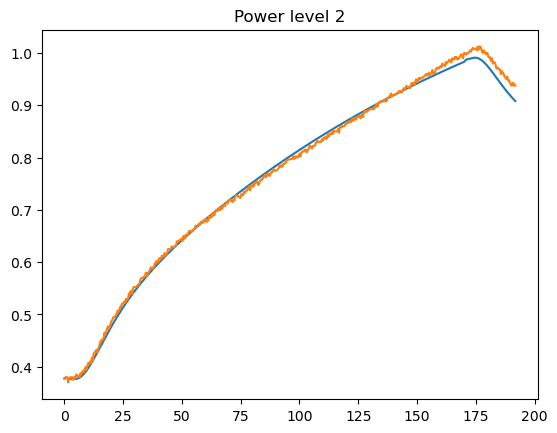

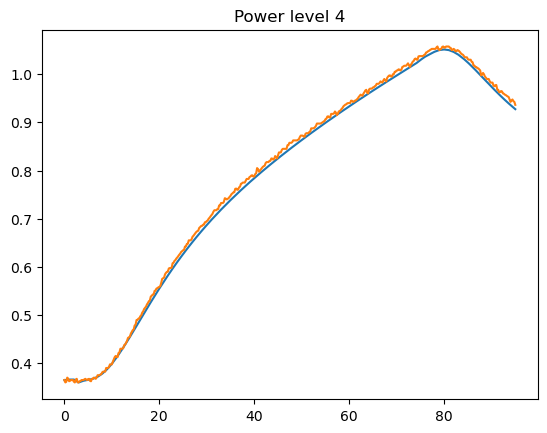

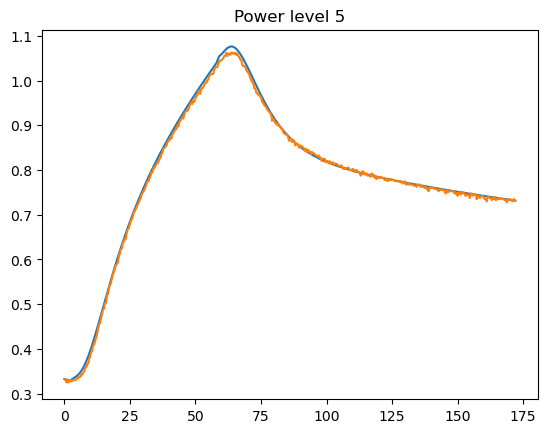

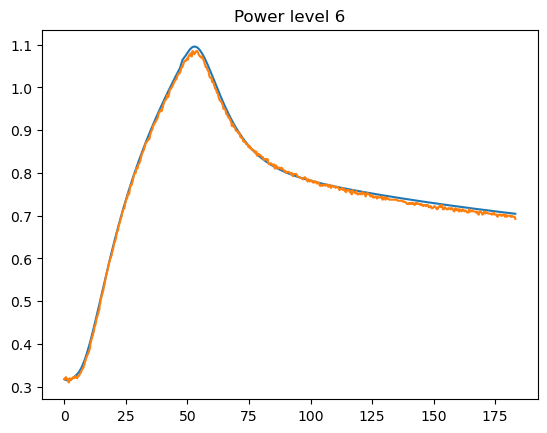

In [11]:
for i in data_torch.keys():
    t = data_torch[i]["t"].detach().numpy()
    T_pred = model(data_torch[i]["t"], data_torch[i]["u"], data_torch[i]["x0"]).detach().numpy()
    T_true = data_torch[i]["T"].detach().numpy()
    plt.plot(t.squeeze(), T_pred[0,:,0], label="predicted")
    plt.plot(t.squeeze(), T_true[0,:,0], label="true")
    plt.title("Power level %d" % i )
    plt.show()

In [42]:
import pickle
pickle.dump((A,B,c), open("temp_dynamics.p", "wb"))

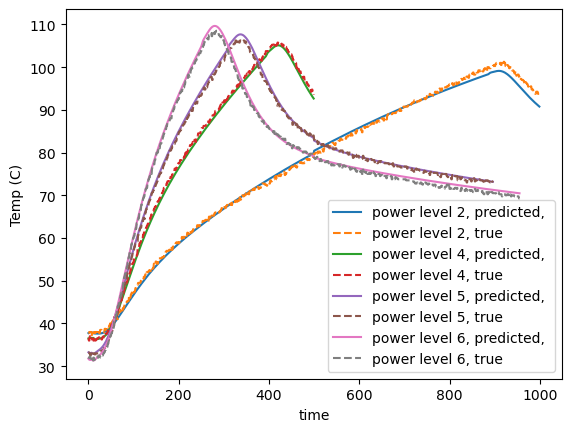

In [48]:
# sanity check
def ddt(x, t, u, tu):
    ut = np.array([np.interp(t, tu, u)])
    return A@x + B @ ut + c

for i in data.keys():
    t, u, T = data[i]["t"], data[i]["u"], data[i]["T"]

    x0 = T[0] * np.ones(n)
    x = sp.integrate.odeint(ddt, x0, t, (u, t))

    plt.plot(x[:,0], label="power level %d, predicted, " % i)
    plt.plot(T, "--", label="power level %d, true" % i)

plt.legend()
plt.xlabel("time")
plt.ylabel("Temp (C)")
plt.savefig("temp_model.png")
plt.show()